In [1]:
from IPython.display import clear_output
from numpy import max, min

from utils import print_system_info
import tensorflow as tf
import imgaug.augmenters as iaa
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import os
import numpy as np
import matplotlib
from keras.api.layers import Input
from keras.api.models import Model, load_model
from keras.api.layers import Dense
import matplotlib.pyplot as plt
import datetime

from keras import regularizers
from keras.src.applications.mobilenet_v3 import MobileNetV3Large

from keras.api.callbacks import (
    Callback,
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
    EarlyStopping,
    ReduceLROnPlateau
)

import seaborn as sns
from sklearn import metrics

In [2]:
print_system_info()
seed = 73
IMG_SIZE = 224
COLOR_CHANNELS = 3
FRAMES_PER_SECOND = 2
DATASET_DIR = '../datasets/violence'

FROM_FILE = False

MODEL_VERSION = 1
MODEL_NAME = f'violence_v{MODEL_VERSION}'

LOAD_VERSION = 1
KERAS_MODEL_LOAD_FILENAME = f'{MODEL_NAME}_v{LOAD_VERSION}.keras'

SAVE_VERSION = 1
KERAS_MODEL_SAVE_FILENAME = f'{MODEL_NAME}_v{SAVE_VERSION}.keras'
CHECKPOINT_FILEPATH = f"{MODEL_NAME}_v{SAVE_VERSION}.weights.h5"

tf.random.set_seed(seed)

Operating System: Windows-10-10.0.26100-SP0
Python version: 3.11.9
Tensorflow version: 2.19.0


In [3]:
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi


Mon May  5 05:36:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   29C    P8              8W /  160W |    1438MiB /   8188MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [4]:
def video_to_frames(_video):
    vidcap = cv2.VideoCapture(_video)

    frame_rate = vidcap.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(frame_rate // FRAMES_PER_SECOND)
    count = 0

    image_frames = []
    while vidcap.isOpened():
        frame_id = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            if frame_id % frames_to_skip == 0:
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image=image)
                image_aug = random_brightness(image=image_aug)
                image_aug = zoom(image=image_aug)
                image_aug = rotate(image=image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                image_frames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return image_frames

In [5]:
video_data_dir = os.path.join(DATASET_DIR, 'Real Life Violence Dataset')

print('Доступно \n{} видео с агрессией \n{} видео без агрессии'.format(
    len(os.listdir(video_data_dir + '/Violence')),
    len(os.listdir(video_data_dir + '/NonViolence'))))

x_original = []
y_original = []

# Выбор случайных 1000 видео для решения проблем с памятью
# 500 с агрессией и 500 без
VIDEOS_PER_CLASS = 500
CLASSES = ["NonViolence", "Violence"]

for category in CLASSES:
    path = os.path.join(video_data_dir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[:VIDEOS_PER_CLASS])):
        frames = video_to_frames(os.path.join(path, video))
        for j, frame in enumerate(frames):
            x_original.append(frame)
            y_original.append(class_num)

Доступно 
1000 видео с агрессией 
1000 видео без агрессии


100%|██████████| 500/500 [01:04<00:00,  7.79it/s]


In [6]:
x_original = np.array(x_original).reshape(-1, IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
print(len(x_original))

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=seed)

for train_index, test_index in stratified_sample.split(x_original, y_original):
    x_train, x_test = x_original[train_index], x_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]


def preprocess_input(x):
    x = x.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS) / 255.0
    # Модель ожидает на вход от -1.0 до 1.0
    return (x - 0.5) * 2.0


x_train_nn = preprocess_input(x_train)
x_test_nn = preprocess_input(x_test)

10919


## **Model Training**

In [7]:
clear_output()

In [8]:
matplotlib.use("Agg")
print(min(x_train_nn))
print(max(x_train_nn))

-1.0
1.0


In [9]:
epochs = 50
kernel_regularizer = regularizers.l2(0.0001)


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS))
    base_model = MobileNetV3Large(
        pooling='avg',
        include_top=False,
        include_preprocessing=False,
        input_tensor=input_tensor,
        input_shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    )

    print(input_tensor)
    head_model = base_model.output
    head_model = Dense(1, activation="sigmoid", kernel_regularizer=kernel_regularizer)(head_model)
    _model = Model(inputs=base_model.input, outputs=head_model)

    for layer in base_model.layers:
        layer.trainable = False

    print("Compiling model...")
    _model.compile(loss="binary_crossentropy",
                   optimizer='adam',
                   metrics=["accuracy"])

    return _model


if FROM_FILE:
    model = load_model(KERAS_MODEL_SAVE_FILENAME)
else:
    if TPU_INIT:
        with tpu_strategy.scope():
            model = load_layers()
    else:
        model = load_layers()
model.summary()

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>
Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ expanded_conv_1_

 Total params: 2,997,313 (11.43 MB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [10]:
PATIENCE = 3

START_LR = 0.00001
MIN_LR = 0.00001
MAX_LR = 0.00005

BATCH_SIZE = 4
RAMP_UP_EPOCHS = 5
SUSTAIN_EPOCHS = 0
EXP_DECAY = .8
EARLY_STOP_ACCURACY = 0.999

if TPU_INIT:
    MAX_LR *= tpu_strategy.num_replicas_in_sync
    BATCH_SIZE *= tpu_strategy.num_replicas_in_sync


def lr_fn(epoch):
    if epoch < RAMP_UP_EPOCHS:
        lr = (MAX_LR - START_LR) / RAMP_UP_EPOCHS * epoch + START_LR
    elif epoch < RAMP_UP_EPOCHS + SUSTAIN_EPOCHS:
        lr = MAX_LR
    else:
        decay_epoch = epoch - RAMP_UP_EPOCHS - SUSTAIN_EPOCHS
        lr = (MAX_LR - MIN_LR) * (EXP_DECAY ** decay_epoch) + MIN_LR
    return lr


class EarlyStopCallback(Callback):
    def __init__(self, target_acc=EARLY_STOP_ACCURACY):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy')

        if accuracy >= self.target_acc:
            print("\nДостигнут лимит остановки обучения!")
            self.model.stop_training = True

In [11]:
def build_callbacks(checkpoint_filepath=CHECKPOINT_FILEPATH, log_dir="logs/fit/"):
    log_dir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    _callbacks = [
        EarlyStopCallback(),
        LearningRateScheduler(
            lambda epoch: lr_fn(epoch),
            verbose=False
        ),
        ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True
        ),
        EarlyStopping(
            patience=PATIENCE,
            monitor='val_loss',
            mode='min',
            restore_best_weights=True,
            verbose=1,
            min_delta=.00075
        ),
        ReduceLROnPlateau(
            patience=2,
            mode='min'
        )
    ]

    if not TPU_INIT:
        _callbacks.insert(
            3,
            TensorBoard(
                log_dir=log_dir,
                write_graph=True,
                histogram_freq=1
            )
        )

    return _callbacks


os.system('rm -rf ./logs/')
callbacks = build_callbacks()

In [12]:
def train_model(_model):
    _history = _model.fit(
        x_train_nn,
        y_train,
        validation_data=(x_test_nn, y_test),
        epochs=epochs,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    print(f'\nВосстановление лучших весов для MobileNetV3 из {CHECKPOINT_FILEPATH}')
    _model.load_weights(CHECKPOINT_FILEPATH)

    return _history

In [14]:
%%capture --no-display

history = train_model(model)

In [15]:
%matplotlib inline

def print_graph(_history, metric, best_epoch, save=True):
    plt.figure()

    plt.plot(_history.history[metric], label='Train')
    plt.plot(_history.history[f'val_{metric}'], label='Val')

    if best_epoch is not None:
        plt.axvline(best_epoch, linestyle='--', color='gray', alpha=0.6, label='Best Epoch')

    plt.title(f'{metric.capitalize()} по эпохам')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

    if save:
        plot = '{}.png'.format(metric)
        plt.savefig(plot)
    plt.show()


def model_summary(_model, _history, _x_test, _y_test):
    print('---' * 30)
    test_loss, test_accuracy = _model.evaluate(_x_test, _y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f} | Test Loss: {test_loss:.4f}")

    # Определим лучшую эпоху по минимальному val_loss
    if _history:
        val_losses = _history.history['val_loss']
        best_epoch = int(np.argmin(val_losses))

        print(f'Лучшая эпоха: {best_epoch}')
        print(f"Train Acc: {_history.history['accuracy'][best_epoch]:.4f} | "
              f"Train Loss: {_history.history['loss'][best_epoch]:.4f}")

        print_graph(_history, 'accuracy', best_epoch)
        print_graph(_history, 'loss', best_epoch)
        print('---' * 30)

------------------------------------------------------------------------------------------


C:\Users\velde\PycharmProjects\PythonProject3\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


Test Accuracy: 0.9618 | Test Loss: 0.1159
Лучшая эпоха: 49
Train Acc: 0.9678 | Train Loss: 0.1072


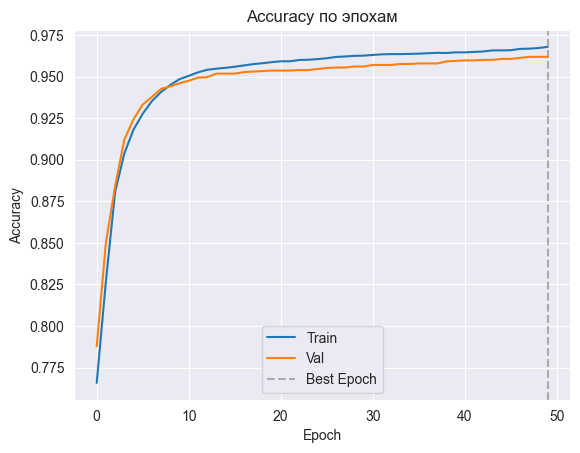

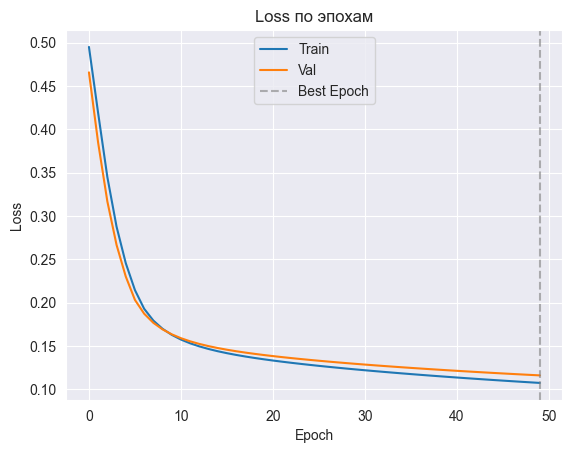

------------------------------------------------------------------------------------------


In [16]:
model_summary(model, history, x_test_nn, y_test)

## **Evaluation on test set**

Проверка модели...


C:\Users\velde\PycharmProjects\PythonProject3\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


102/103 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

C:\Users\velde\PycharmProjects\PythonProject3\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


103/103 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step
> Correct Predictions: 3151
> Wrong Predictions: 125


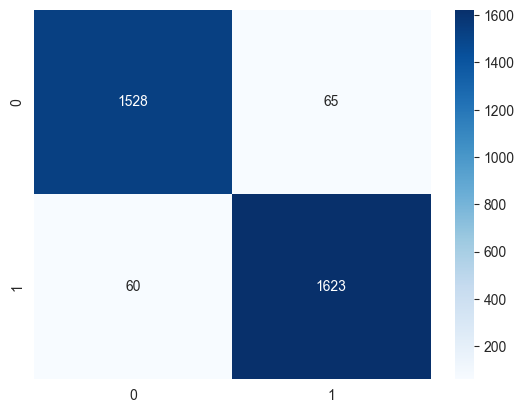

              precision    recall  f1-score   support

 NonViolence       0.96      0.96      0.96      1593
    Violence       0.96      0.96      0.96      1683

    accuracy                           0.96      3276
   macro avg       0.96      0.96      0.96      3276
weighted avg       0.96      0.96      0.96      3276



In [17]:
# evaluate the network
print("Проверка модели...")
predictions = model.predict(x_test_nn)
preds = predictions > 0.5
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.uint64((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.uint((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                                    target_names=["NonViolence", "Violence"]))


=== Проверка модели ===
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 227ms/step
> Correct Predictions: 3151
> Wrong Predictions: 125

Confusion Matrix:


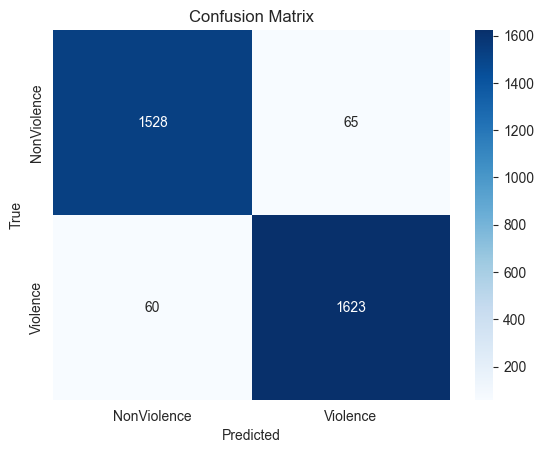


Classification Report:
              precision    recall  f1-score   support

 NonViolence       0.96      0.96      0.96      1593
    Violence       0.96      0.96      0.96      1683

    accuracy                           0.96      3276
   macro avg       0.96      0.96      0.96      3276
weighted avg       0.96      0.96      0.96      3276

ROC-AUC: 0.9932


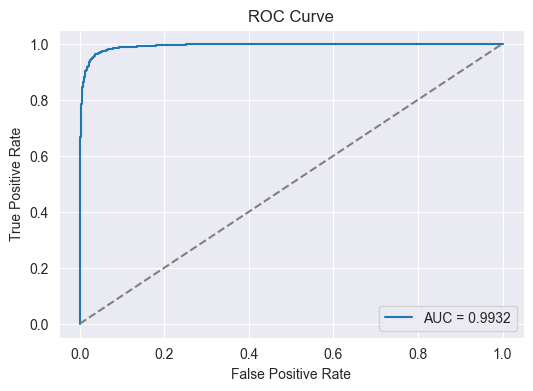

In [19]:
def evaluate_model(_model, _x_test, _y_test, threshold=0.5):
    print("\n=== Проверка модели ===")
    _predictions = _model.predict(_x_test, batch_size=64, verbose=1).flatten()
    predictions_binary = (_predictions > threshold).astype(int)

    # Confusion matrix
    cm = metrics.confusion_matrix(_y_test, predictions_binary)
    correct = np.sum(np.diag(cm))
    total = np.sum(cm)

    print(f"> Correct Predictions: {correct}")
    print(f"> Wrong Predictions: {total - correct}")
    print("\nConfusion Matrix:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["NonViolence", "Violence"],
                yticklabels=["NonViolence", "Violence"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(metrics.classification_report(_y_test, predictions_binary,
                                        target_names=["NonViolence", "Violence"]))

    auc = metrics.roc_auc_score(_y_test, _predictions)
    print(f"ROC-AUC: {auc:.4f}")

    # ROC Curve
    fpr, tpr, _ = metrics.roc_curve(_y_test, _predictions)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


evaluate_model(model, x_test_nn, y_test)

In [20]:
model.save(KERAS_MODEL_SAVE_FILENAME)